# Install Library

In [1]:
!pip install torch torchvision matplotlib numpy pillow

# Import Library

In [2]:
import os
import zipfile
import time
import matplotlib.pyplot as plt
import numpy as np
import random

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import DataLoader, random_split
from torchvision import datasets, models
from PIL import Image
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau

# Device Configuration and Reproducibility

In [3]:
device = torch.device("cpu")

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.empty_cache()
    device_count = torch.cuda.device_count()
    print(f'Device count: {device_count}')
    
    for idx in range(device_count):
        print(f'GPU: {idx}: {torch.cuda.get_device_name(idx)} :: device use: {device}')
else:
    print("GPU not found.")
    
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

Device count: 1
GPU: 0: NVIDIA GeForce RTX 3060 Laptop GPU :: device use: cuda


# Computing Dataset Mean and Standard Deviation

##### The function **compute_mean_std(dataset)** is designed to calculate the mean and standard deviation of image data in the dataset for each color channel (e.g., RGB channels)

#### Benefits:
- ##### Normalizing data using the mean and standard deviation calculated from the dataset helps stabilize the learning process of the model.
- ##### It aids in preparing the data to be compatible with the use of pre-trained models in various research applications.

In [4]:
def compute_mean_std(dataset):
    # สร้าง DataLoader ชั่วคราวเพื่อโหลดข้อมูลทั้งหมด
    temp_loader = DataLoader(dataset, batch_size=1, shuffle=False)

    # สร้าง tensor เพื่อเก็บข้อมูลทั้งหมด
    mean = torch.zeros(3, device=device)  # กำหนด mean ใน device
    std = torch.zeros(3, device=device)    # กำหนด std ใน device
    total_images = 0

    # คำนวณ mean และ std
    for images, _ in temp_loader:
        images = images.to(device)  # ย้ายข้อมูลไปที่อุปกรณ์ที่มีอยู่
        batch_mean = images.mean([0, 2, 3])  # คำนวณ mean ของแต่ละช่องสี
        batch_std = images.std([0, 2, 3])    # คำนวณ std ของแต่ละช่องสี

        mean += batch_mean
        std += batch_std
        total_images += 1

    mean /= total_images  # แบ่งด้วยจำนวนภาพเพื่อหาค่า mean โดยรวม
    std /= total_images    # แบ่งด้วยจำนวนภาพเพื่อหาค่า std โดยรวม

    return mean, std  # คืนค่าที่อยู่ใน device

# Loading Image Data and Computing Normalization Parameters

In [5]:
# Route ไปยังโฟลเดอร์ที่มีข้อมูล
zip_file_path = './MO_34.zip'
extracted_folder_path = './'

# แตกไฟล์ zip
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder_path)

data_folder = os.path.join(extracted_folder_path, 'MO_34')

dataset_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),  # แปลงภาพเป็น tensor
])

# โหลดข้อมูลโดยใช้ ImageFolder
dataset = datasets.ImageFolder(root=data_folder, transform=dataset_transform)

# คำนวณ mean และ std
mean, std = compute_mean_std(dataset)

mean_cpu = mean.cpu()
std_cpu = std.cpu()

print(f'Mean: {mean}, on CPU: {mean_cpu}')
print(f'STD: {std}, on CPU: {std_cpu}')

Mean: tensor([0.4293, 0.3925, 0.3282], device='cuda:0'), on CPU: tensor([0.4293, 0.3925, 0.3282])
STD: tensor([0.2249, 0.2143, 0.2053], device='cuda:0'), on CPU: tensor([0.2249, 0.2143, 0.2053])


# Data Augmentation and Normalization for Training, Validation and Testing

In [6]:
# Train Transform
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),          # ครอบภาพแบบสุ่มในขนาด 224x224
    transforms.RandomHorizontalFlip(),          # พลิกภาพซ้ายขวาแบบสุ่ม
    transforms.RandomRotation(10),              # หมุนภาพแบบสุ่มไม่เกิน 10 องศา
    transforms.ColorJitter(                     # ปรับแสงสีของภาพ
        brightness=0.3,                         # ความสว่าง
        contrast=0.3,                           # ความต่างของแสง
        saturation=0.3,                         # ความอิ่มตัวของสี
        hue=0.3                                 # เฉดสี
    ),                                          
    transforms.RandomAffine(                    # การบิดรูปภาพแบบสุ่ม
        degrees=15, translate=(0.1, 0.1), scale=(0.8, 1.2)), 
    transforms.RandomPerspective(               # การบิดมุมมองของภาพ
        distortion_scale=0.5, p=0.5),           
    transforms.RandomGrayscale(p=0.2),          # เปลี่ยนภาพเป็นขาว-ดำในบางครั้ง (20% ของภาพทั้งหมด)
    transforms.ToTensor(),                      # แปลงภาพเป็น Tensor
    transforms.Normalize(mean=mean_cpu, std=std_cpu),  # ใช้ mean และ std ที่คำนวณได้
])

# Valid & Test Transform
transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_cpu, std=std_cpu),  # ใช้ mean และ std ที่คำนวณได้
])

# Dataset Splitting and DataLoader Preparation

In [7]:
# กำหนดสัดส่วนในการแบ่งข้อมูล (60% train, 10% valid, 30% test)
train_size = int(0.6 * len(dataset))
valid_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - valid_size

# แบ่งข้อมูลเป็น train, valid และ test
train_dataset, valid_dataset, test_dataset = random_split(dataset, [train_size, valid_size, test_size])

# ใช้ transform ต่างกันสำหรับ train, valid และ test
train_dataset.dataset.transform = transform_train  # เพิ่ม transform สำหรับ train
valid_dataset.dataset.transform = transform_test   # เพิ่ม transform สำหรับ valid
test_dataset.dataset.transform = transform_test    # เพิ่ม transform สำหรับ test

# สร้าง DataLoader สำหรับ train, valid และ test
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=128, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=4)



### PreCheck ###

# ตรวจสอบขนาดข้อมูล
print(f'Train size: {len(train_loader.dataset)}')
print(f'Valid size: {len(valid_loader.dataset)}')
print(f'Test size: {len(test_loader.dataset)}')

# ตรวจสอบ class names และการแมพไปยัง integer label
print(dataset.class_to_idx)  # mapping ของชื่อคลาสไปยัง labels
print(f'Len of Classes: {len(dataset.classes)}')

Train size: 5757
Valid size: 959
Test size: 2879
{'Agaricus augustus': 0, 'Amanita calyptroderma': 1, 'Artomyces pyxidatus': 2, 'Boletus pallidus': 3, 'Coprinellus micaceus': 4, 'Crucibulum laeve': 5, 'Cryptoporus volvatus': 6, 'Flammulina velutipes': 7, 'Ganoderma tsugae': 8, 'Grifola frondosa': 9, 'Hericium erinaceus': 10, 'Hypomyces lactifluorum': 11, 'Hypsizygus tessellatus': 12, 'Lactarius indigo': 13, 'Laetiporus sulphureus': 14, 'Lentinula edodes': 15, 'Leratiomyces ceres': 16, 'Leucoagaricus leucothites': 17, 'Lycoperdon pyriforme': 18, 'Phyllotopsis nidulans': 19, 'Pleurotus pulmonarius': 20, 'Pseudohydnum gelatinosum': 21, 'Psilocybe cubensis': 22, 'Psilocybe pelliculosa': 23, 'Retiboletus ornatipes': 24, 'Schizophyllum commune': 25, 'Stereum ostrea': 26, 'Stropharia ambigua': 27, 'Suillus luteus': 28, 'Trametes betulina': 29, 'Trametes gibbosa': 30, 'Tuber melanosporum': 31, 'Tylopilus felleus': 32, 'Volvopluteus gloiocephalus': 33}
Len of Classes: 34


# Training and Validation Functions for Model Training

In [8]:
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Compute loss and accuracy
        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc
    
def validate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc


# Hyperparameter Configuration

In [9]:
num_classes = 34

num_epochs = 10

learning_r = 0.0001
decay = 1e-5
gamma_r = 0.1

# Model Initialization and Modification

In [10]:
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model.to(device)

C:\Users\Acer\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Acer\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# Loss Function, Optimizer, and Learning Rate Scheduler Configuration

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_r, weight_decay=decay)
# optimizer = optim.AdamW(model.parameters(), lr=learning_r, weight_decay=decay)
# optimizer = optim.RMSprop(model.parameters(), lr=learning_r, weight_decay=decay)
# optimizer = optim.SGD(model.parameters(), lr=learning_r, momentum=0.9, weight_decay=decay)

scheduler = StepLR(optimizer, step_size=7, gamma=gamma_r)

# Training and Validation Loop with Performance Visualization

Epoch 1/10, Train Loss: 2.0918, Train Acc: 52.49%, Val Loss: 1.0853, Val Acc: 74.97%
Epoch 2/10, Train Loss: 0.7171, Train Acc: 86.57%, Val Loss: 0.7551, Val Acc: 83.21%
Epoch 3/10, Train Loss: 0.3204, Train Acc: 95.69%, Val Loss: 0.6268, Val Acc: 83.63%
Epoch 4/10, Train Loss: 0.1365, Train Acc: 99.17%, Val Loss: 0.5327, Val Acc: 86.65%
Epoch 5/10, Train Loss: 0.0581, Train Acc: 99.98%, Val Loss: 0.4929, Val Acc: 87.80%
Epoch 6/10, Train Loss: 0.0328, Train Acc: 99.98%, Val Loss: 0.4750, Val Acc: 87.49%
Epoch 7/10, Train Loss: 0.0209, Train Acc: 100.00%, Val Loss: 0.4673, Val Acc: 87.70%
Epoch 8/10, Train Loss: 0.0167, Train Acc: 100.00%, Val Loss: 0.4646, Val Acc: 87.80%
Epoch 9/10, Train Loss: 0.0159, Train Acc: 100.00%, Val Loss: 0.4622, Val Acc: 88.01%
Epoch 10/10, Train Loss: 0.0154, Train Acc: 100.00%, Val Loss: 0.4618, Val Acc: 87.80%


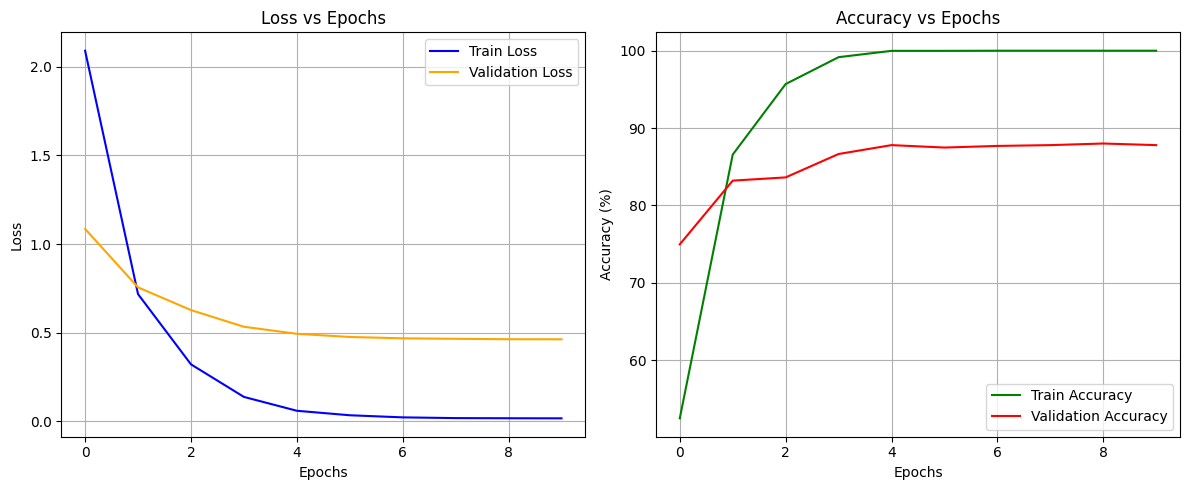

In [12]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate(model, valid_loader, criterion, device)
    
    # Append metrics to lists
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    print(f'Epoch {epoch+1}/{num_epochs}, '
          f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, '
          f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

    scheduler.step()

# Plotting the results
plt.figure(figsize=(12, 5))

# Subplot for Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

# Subplot for Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy', color='green')
plt.plot(val_accuracies, label='Validation Accuracy', color='red')
plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

# Model Saving

In [13]:
torch.save(model.state_dict(), f'model_trainded_resnet18_val_acc-[{val_acc:.2f}]_VVV.pth')

# Loading a Pretrained Model

In [21]:
model = models.resnet18(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model.load_state_dict(torch.load(f'model_trainded_resnet18_val_acc-[{val_acc:.2f}]_VVV.pth', weights_only=True))
# model.load_state_dict(torch.load(f'model_trainded_resnet18_93.12.pth', weights_only=True))

model = model.to(device)

# Testing the Model

In [22]:
def test(model, test_loader, criterion, device):
    
    model.eval()  # Set the model to evaluation mode
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient calculation
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Update test loss
            test_loss += loss.item()
            
            # Calculate predictions
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Average loss and accuracy
    test_loss /= len(test_loader)
    test_accuracy = 100 * correct / total

    return test_loss, test_accuracy

In [23]:
test_loss, test_accuracy = test(model, test_loader, criterion, device)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

Test Loss: 0.4138, Test Accuracy: 88.47%


# Data Transformations and Class Information Before Prediction

In [24]:
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_cpu, std=std_cpu),
])

classes = dataset.classes
print(classes)

['Agaricus augustus', 'Amanita calyptroderma', 'Artomyces pyxidatus', 'Boletus pallidus', 'Coprinellus micaceus', 'Crucibulum laeve', 'Cryptoporus volvatus', 'Flammulina velutipes', 'Ganoderma tsugae', 'Grifola frondosa', 'Hericium erinaceus', 'Hypomyces lactifluorum', 'Hypsizygus tessellatus', 'Lactarius indigo', 'Laetiporus sulphureus', 'Lentinula edodes', 'Leratiomyces ceres', 'Leucoagaricus leucothites', 'Lycoperdon pyriforme', 'Phyllotopsis nidulans', 'Pleurotus pulmonarius', 'Pseudohydnum gelatinosum', 'Psilocybe cubensis', 'Psilocybe pelliculosa', 'Retiboletus ornatipes', 'Schizophyllum commune', 'Stereum ostrea', 'Stropharia ambigua', 'Suillus luteus', 'Trametes betulina', 'Trametes gibbosa', 'Tuber melanosporum', 'Tylopilus felleus', 'Volvopluteus gloiocephalus']


# Grad-CAM Implementation for Visualizing Model Predictions

### Description:
- This code snippet implements the Grad-CAM (Gradient-weighted Class Activation Mapping) technique, which provides insights into the decision-making process of convolutional neural networks (CNNs) by visualizing the regions of the input image that are important for a specific class prediction. The Grad-CAM approach highlights the relevant areas of the image, enabling users to interpret the model's predictions effectively.

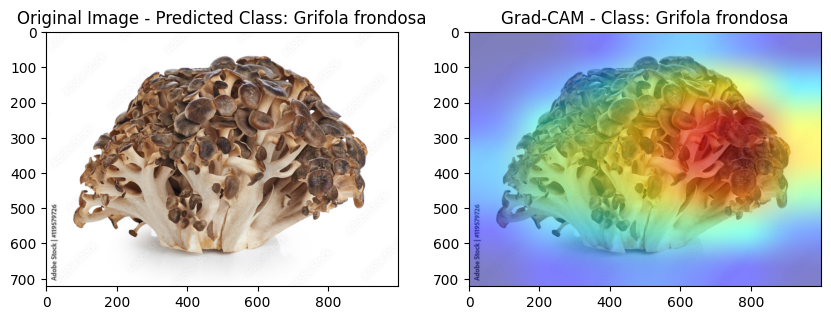

Image: 1000_F_119579726_4I4nfAbHTyrPk7KJkocoPKjT0bCOgBXb.jpg, Predicted Class: Grifola frondosa


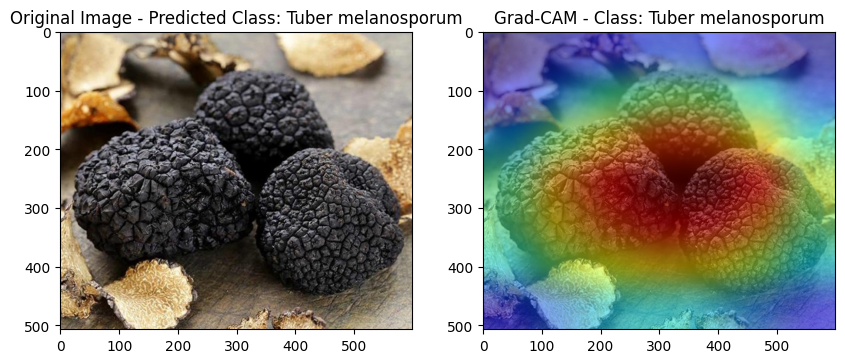

Image: 266479.jpg, Predicted Class: Tuber melanosporum


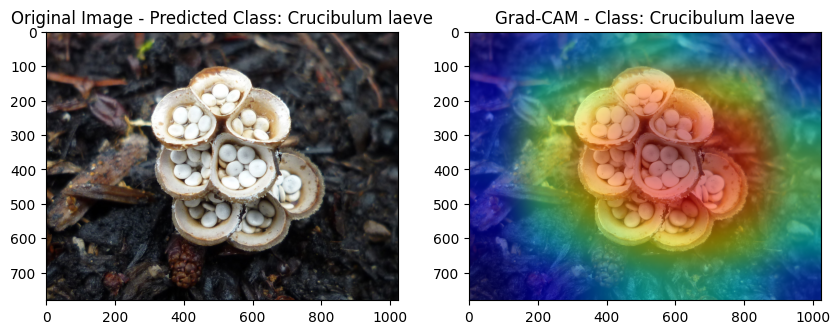

Image: 4350484444_100bb44699_b.jpg, Predicted Class: Crucibulum laeve


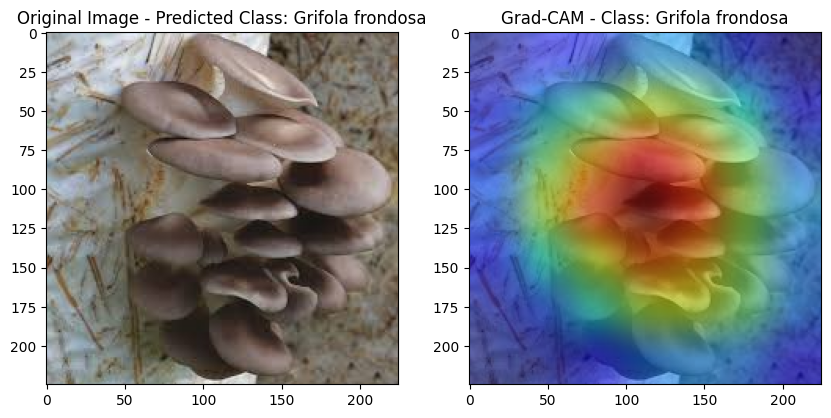

Image: images.jpg, Predicted Class: Grifola frondosa


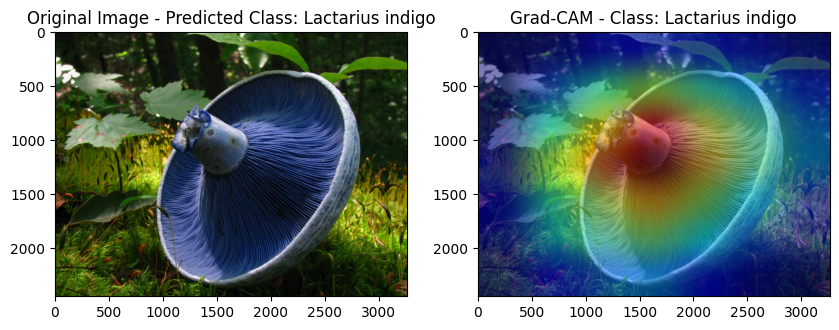

Image: Lactarius_indigo_48568_edit.jpg, Predicted Class: Lactarius indigo


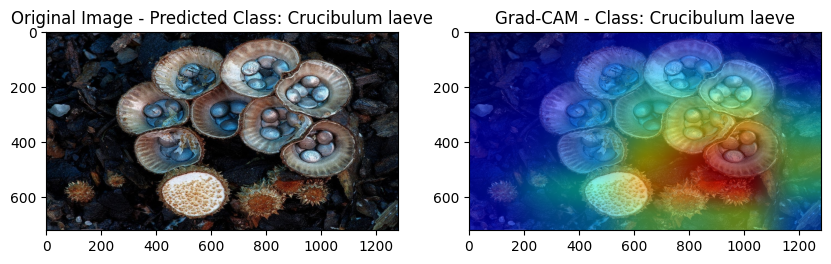

Image: maxresdefault.jpg, Predicted Class: Crucibulum laeve


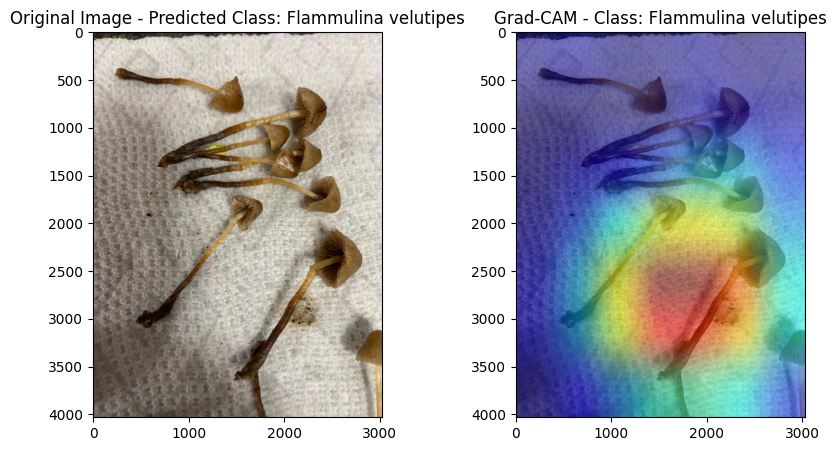

Image: psilocybe-pelliculosa-v0-7sc2n1zdar5c1.jpg, Predicted Class: Flammulina velutipes


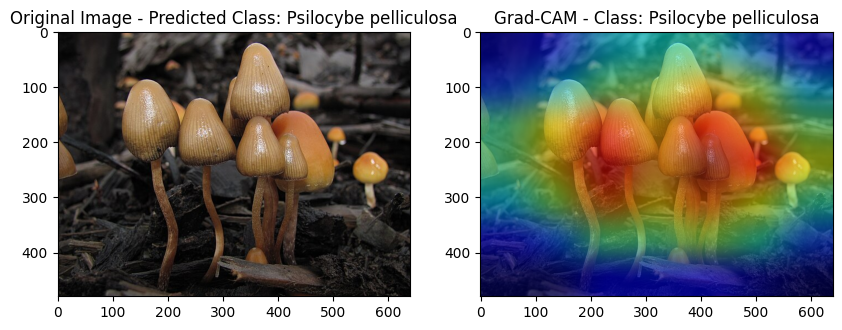

Image: Psilocybe_pelliculosa_122504.jpg, Predicted Class: Psilocybe pelliculosa


In [26]:
# Grad-CAM class
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        # Hook เพื่อดึง activations
        target_layer.register_forward_hook(self.save_activation)
        target_layer.register_full_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]
        
    def __call__(self, input_image, target_class):
        # ให้ input_image มี requires_grad=True
        input_image.requires_grad_()

        # Forward pass
        output = self.model(input_image)
        target = output[:, target_class]

        # Backward pass เพื่อดึง gradients
        self.model.zero_grad()
        target.backward(retain_graph=True)

        # ดึง gradients และ activations
        gradients = self.gradients.detach().cpu().numpy()
        activations = self.activations.detach().cpu().numpy()

        # คำนวณ Grad-CAM
        weights = gradients.mean(axis=(2, 3), keepdims=True)
        cam = (weights * activations).sum(axis=1)
        cam = np.maximum(cam, 0)  # ReLU
        cam = cam / np.max(cam)  # Normalize
        
        return cam

# ใช้เลเยอร์ 'layer4' ของ ResNet18
grad_cam = GradCAM(model, model.layer4)


# ฟังก์ชันสำหรับทำนายและใช้ Grad-CAM
def predict_and_gradcam_image(image_path, model, grad_cam, device):
    try:
        # เปิดภาพ
        image = Image.open(image_path).convert("RGB")
    except Exception as e:
        print(f"Error loading image {image_path}: {e}")
        return

    # การแปลงภาพ
    transformed_image = data_transforms(image).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        outputs = model(transformed_image)
        _, predicted = torch.max(outputs, 1)

    predicted_class = predicted.item()

    # ใช้ Grad-CAM
    cam = grad_cam(transformed_image, predicted_class)
    cam = cam[0]  # ใช้ภาพแรก

    # คำนวณ Grad-CAM
    cam = np.maximum(cam, 0)  # ใช้ ReLU
    cam = cam / np.max(cam) if np.max(cam) > 0 else cam  # Normalize เพื่อหลีกเลี่ยงการแบ่งด้วยศูนย์
    cam = np.uint8(255 * cam)  # เปลี่ยนเป็น uint8

    # สร้างภาพ Heatmap
    heatmap = plt.cm.jet(cam)[:, :, :3]  # ใช้ colormap 'jet'
    heatmap = Image.fromarray((heatmap * 255).astype(np.uint8)).resize(image.size, Image.BICUBIC)  # ปรับขนาดให้ตรงกัน

    # ซ้อน Grad-CAM บนภาพต้นฉบับ
    superimposed_img = Image.blend(image, heatmap, alpha=0.5)

    # แสดงผล
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title(f"Original Image - Predicted Class: {classes[predicted_class]}")
    
    plt.subplot(1, 2, 2)
    plt.imshow(superimposed_img)
    plt.title(f"Grad-CAM - Class: {classes[predicted_class]}")
    plt.show()

    return predicted_class
    
# Loop ผ่านภาพที่อยู่ในโฟลเดอร์
image_folder = './predict'
image_paths = [os.path.join(image_folder, image) for image in os.listdir(image_folder)[:]]

for image_path in image_paths:
    predicted_class = predict_and_gradcam_image(image_path, model, grad_cam, device)
    print(f"Image: {os.path.basename(image_path)}, Predicted Class: {classes[predicted_class]}")